

Finished.


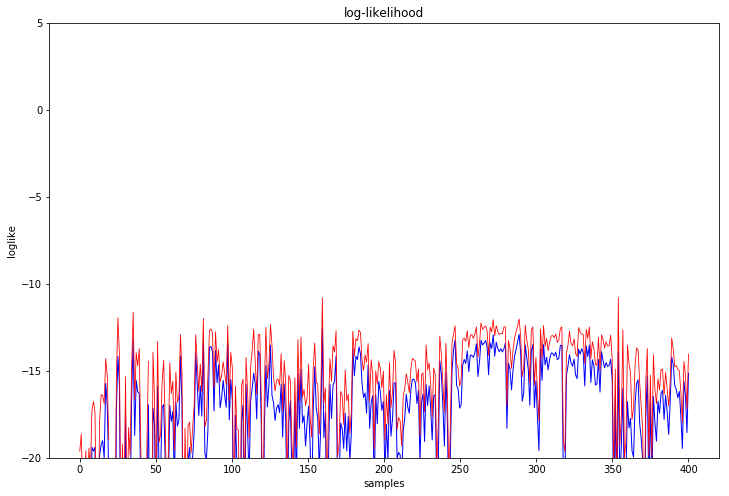

In [12]:
import numpy as np
import argparse
import json
import sys
import os
import torch
import math

# Internal libraries
import excitation_kernels
import hawkes_model_single


from make_data_for_samples import make_data              #多个样本数据
from make_data_for_estimate import make_estimate_data    #单个样本数据

import numpy as np
import matplotlib.pyplot as plt

global result

def make_object(module, name, args):
    return getattr(module, name)(**args)

param_dict_exitation = {'exitation':{'name': 'ExponentialKernel', 'args': {'decay':0.3, 'cut_off': 1000.0}}}

def decision_fun(mu,W, new_events, M ,param_dict, nu, sigma):
    events_num = len(new_events)
    dim = len(new_events[0])
    n_params = dim * (M * dim + 1)
    #3倍上界
    up =  math.exp(nu) * (math.exp(sigma))**3
    #3倍下界
    down = math.exp(nu) / (math.exp(sigma))**3    
    
    # Init Hawkes process model object
    excitation_obj = make_object(excitation_kernels, **param_dict['exitation'])
    hawkes_model_obj = hawkes_model_single.HawkesModel(excitation=excitation_obj, verbose=False)

    loglik_all=[]
    #loglik=[0.0,0.0]
    
    W = W.view(dim,dim,M)

    for i in range(events_num):
        hawkes_model_obj.set_data(new_events[i])
        #print(new_events[i])
        loglik=[0.0,0.0]
        #loglik_zero = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=0)
        loglik_max = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=up)
        loglik_min = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=down)
        loglik[0] = loglik_min.item()
        loglik[1] = loglik_max.item()
        loglik_all.append(loglik)
        '''
        if loglik[0]<-6.0:
            print('\nmin is:',i)
        if loglik[1]<-6.0:
            print('\nmax is:',i)
        '''
    return loglik_all

def estimate(exp_dir, param_filename, stdout=None, stderr=None):
    if stdout is not None:
        sys.stdout = open(stdout, 'w')
    if stderr is not None:
        sys.stderr = open(stderr, 'w')
   
    data_fileName = "./data/DSL-StrongPasswordData.xls"
    events = make_data('s036',12000,12400,data_fileName)
    #events = make_data('s047',16000,16400,data_fileName)
    #events = make_data('s052',18000,18400,data_fileName)
    #events = make_data('s032',10400,10800,data_fileName)
    #events = make_data('s010',2400,2800,data_fileName)
    #events = make_data('s008',2000,2400,data_fileName)
    #events = make_data('s007',1600,2000,data_fileName)
    #events = make_data('s005',1200,1600,data_fileName)
    #events = make_data('s004',800,1200,data_fileName)
    #events = make_data('s003',400,800,data_fileName)
    #events = make_data('s002',0,400,data_fileName)
    n_jumps_per_dim = list(map(len, events[0]))
    n_nodes = len(events[0])
    #print('Number of jumps:', len(events)*sum(n_jumps_per_dim))
    #print('per node:', n_jumps_per_dim)
    
    events = torch.tensor(events, dtype=torch.float32)
    
    #print('\nestimating')
    #print('=========')

    param_filename = os.path.join(exp_dir, param_filename)
    if not os.path.exists(param_filename):
        raise FileNotFoundError(
            'Input file `{:s}` not found.'.format(param_filename))
    with open(param_filename, 'r') as param_file:
        param_dict = json.load(param_file)
        
    mu = torch.tensor(param_dict['vi_exp']['mu'],dtype=torch.float32)
    W = torch.tensor(param_dict['vi_exp']['adjacency'],dtype=torch.float32)
    
    #W = W.view(n_nodes,n_nodes)
    
    #print('mu:',mu)
    #print('W:',W)
    
    #nu =  -1.2679313870422824
    #sigma = 0.06287491877674098
    
    nu = param_dict['vi_exp']['nu']
    sigma = param_dict['vi_exp']['sigma']
    
    global result        
    result = decision_fun(mu=mu, W=W, new_events=events, M=1 ,param_dict=param_dict_exitation, nu=nu, sigma=sigma)
    #print(result)
    # Log that the run is finished
    print('\n\nFinished.')


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-d', '--dir', dest='dir', type=str,
                        #required=True, help="Working directory")
                        required=False, default=".")
    parser.add_argument('-p', '--params', dest='param_filename', type=str,
                        required=False, default='params.json',
                        help="Input parameter file (JSON)")
    args = parser.parse_known_args()[0]
    estimate ('.','./result/2/penalty10+decay0.3+1e-04+c1+epsilon=-3.0/penalty10_decay0.3+s047_16000-16200.json')
    
    x = np.linspace(0, 400, 400)
    y1=[]
    y2=[]
    for i in range(len(result)):
        y1.append(result[i][0])
        y2.append(result[i][1])
    plt.figure(figsize=(12,8))
    plt.plot(x,y1,color="blue",linewidth=1 )
    plt.plot(x,y2,color="red",linewidth=0.8)
    plt.xlabel("samples") #xlabel、ylabel：分别设置X、Y轴的标题文字。
    plt.ylabel("loglike")
    plt.title("log-likelihood") # title：设置子图的标题。
    plt.ylim(-20.0,5.0)# xlim、ylim：分别设置X、Y轴的显示范围。
    #plt.savefig('quxiantu.png',dpi=120,bbox_inches='tight')
    plt.show()

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.2562, 0.1393, 0.1549, 0.081, 0.1462, 0.057, 1.3501, 1.2535, 1.0669, 0.9843, 0.6546, 0.5255, 0.2112, 0.0795, 0.1083, -0.0351, 0.2072, 0.1203, 1.1307, 1.028]


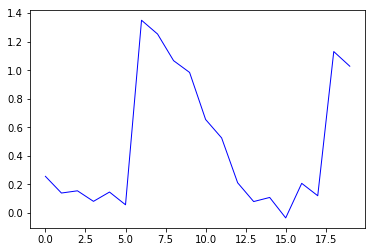

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[14:15]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)
#data_view.plot(style='bo--')


x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.1947, 0.0965, 0.1536, 0.0602, 0.1367, 0.071, 0.5613, 0.4731, 0.4052, 0.3218, 0.1722, 0.0747, 0.1405, 0.0468, 0.1305, 0.027, 0.1674, 0.0982, 1.2663, 1.1681]


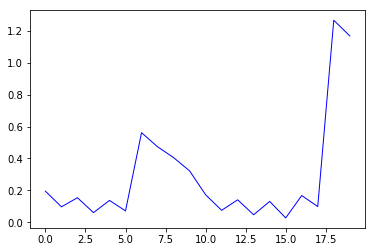

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[75:76]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.2, 0.0891, 0.1391, 0.0486, 0.1653, 0.0882, 0.6244, 0.5373, 0.4268, 0.3534, 0.1631, 0.0441, 0.1769, 0.0787, 0.1265, 0.0193, 0.179, 0.114, 0.2287, 0.1337]


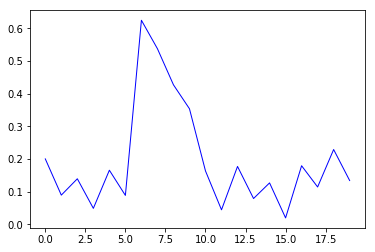

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[78:79]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.054, -0.0165, 0.1975, 0.0977, 0.0581, -0.0069, 0.2957, 0.213, 0.5366, 0.4384, 0.1618, 0.0533, 0.1693, 0.0896, 0.0357, -0.0898, 0.7472, 0.6796, 0.2316, 0.1223]


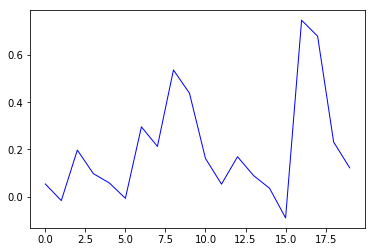

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[219:220]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.1369, 0.0332, 0.1291, 0.0491, 0.0578, -0.0058, 0.4452, 0.3475, 0.3727, 0.2869, 0.1544, 0.0525, 0.1793, 0.1025, 0.2012, 0.093, 0.2137, 0.1377, 0.6953, 0.6137]


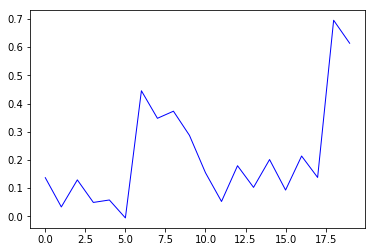

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[225:226]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.1378, 0.0612, 0.1096, 0.0394, 0.1136, 0.0547, 0.3529, 0.2821, 0.365, 0.2811, 0.1236, 0.0214, 0.1693, 0.0811, 0.0964, -0.019, 0.1919, 0.11, 0.1984, 0.1242]


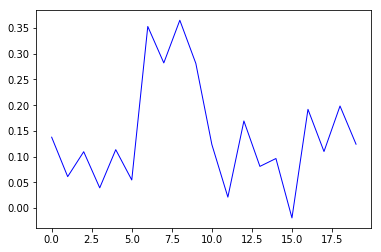

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[226:227]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.1077, 0.0377, 0.1344, 0.0689, 0.0758, 0.0138, 0.2191, 0.1462, 0.6979, 0.6142, 0.1371, 0.0338, 0.1498, 0.0582, 0.1806, 0.0755, 0.2054, 0.1288, 0.1863, 0.1134]


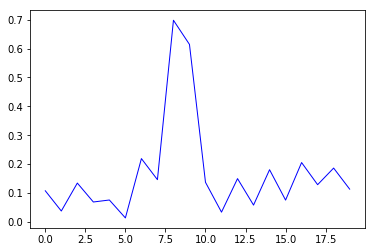

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[227:228]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)

x is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
y is [0.1839, 0.0569, 0.1381, 0.047, 0.1774, 0.0879, 0.6069, 0.533, 0.8047, 0.7266, 0.202, 0.0715, 0.1746, 0.0542, 0.1521, 0.0183, 0.1954, 0.118, 0.2643, 0.1701]


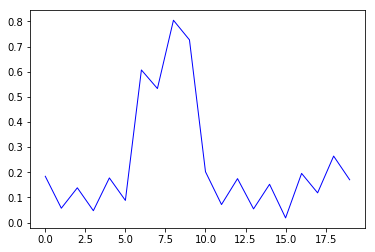

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/DSL-StrongPasswordData.csv')

features = [column for column in df.columns if ('UD' in column) or ('DD' in column)]
#ud_features = [column for column in df.columns if 'UD' in column]
#dd_features = [column for column in df.columns if 'DD' in column]
#hold_features = [column for column in df.columns if 'H' in column]

#df.head()
data_view = df[features]
data_view = data_view.iloc[15:16]
x = [0]*20
y = [0]*20
for i in range(20):
    x[i] = i
    y[i] = 0
    y[i] = data_view.iloc[:,i].item()
print('x is ',x)
print('y is' ,y)
plt.plot(x,y,color="blue",linewidth=1)